In [12]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import plotly.io as pio

from ocean_navigation_simulator.controllers.hj_planners.Platform2dForSim import (
    Platform2dForSim
)
from ocean_navigation_simulator.controllers.hj_planners.Platform2dObsForSim import Platform2dObsForSimToy
pio.renderers.default = "browser"
import time

import hj_reachability as hj
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import xarray as xr
from scipy.interpolate import interp1d
from functools import partial

In [23]:
from hj_reachability import systems

class Platform2DcurrentsObs(systems.Platform2Dcurrents):
    def __init__(self,
                 u_max=1.,
                 d_max=0,
                 control_mode="min",
                 disturbance_mode="max",
                 control_space=None,
                 disturbance_space=None,
                 x_current=None,
                 y_current=None,
                 obs_loc=None,
                 obs_vel=None):

        self.obs_loc = obs_loc
        self.obs_vel = obs_vel
        super().__init__(u_max, d_max, control_mode, disturbance_mode,
                control_space, disturbance_space, x_current, y_current)

    def __call__(self, state, control, disturbance, time):
        return jnp.where(self.obs_loc(jnp.append(state, time)) < 0,
                self.obs_vel(jnp.append(state, time)),
                super().__call__(state, control, disturbance, time))

In [13]:
times = np.linspace(0, -60, 100)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    hj.sets.Box(lo=np.array([-5.0, -5.0]), hi=np.array([5.0, 5.0])), (100, 100)
)
x_init = [-4, -4]
x_target = [4, 4]
r = 0.1
initial_values = hj.shapes.shape_sphere(grid=grid, center=x_target, radius=r)


In [14]:
def multi_reach_step(mask, val):
    val = jnp.where(mask<0,-1,val)
    return val
# TODO: add postprocessor and cls

p_multi_reach_step = partial(multi_reach_step, initial_values)

solver_settings = hj.SolverSettings.with_accuracy("high",
                    x_init = [np.nan, np.nan],#x_init,
                    artificial_dissipation_scheme =
                        hj.artificial_dissipation.local_local_lax_friedrichs,
                    hamiltonian_postprocessor = p_multi_reach_step
                    )

In [15]:
def checkerboard(shape):
    return np.indices(shape).sum(axis=0) % 2

In [16]:
water_u = np.zeros((100, 100, 100))
water_v = np.zeros((100, 100, 100))
obs = np.zeros((100, 100, 100))

# Create checkerboard shaped obstacles
obs[:, 40:60, 40:60] = checkerboard([20, 20])


lon = np.linspace(-5, 5, 100)
lat = np.linspace(-5, 5, 100)
time = np.linspace(0, -60, 100)


In [17]:
ds_obs = xr.Dataset(
    data_vars=dict(
        obstacles=(["relative_time", "lat", "lon"], obs),
    ),
    coords=dict(
        lon=lon,
        lat=lat,
        relative_time=time,
    ),
)

ds_water = xr.Dataset(
    data_vars=dict(
        water_u=(["relative_time", "lat", "lon"], water_u),
        water_v=(["relative_time", "lat", "lon"], water_v),
    ),
    coords=dict(
        lon=lon,
        lat=lat,
        relative_time=time,
    ),
)

In [18]:
Plat2D = Platform2dForSim(#Platform2dObsForSimToy(
    u_max=0.1,
    d_max=0,
    use_geographic_coordinate_system=False,
    control_mode="min",
    disturbance_mode="max",
    #obstacle_ds=ds_obs
)

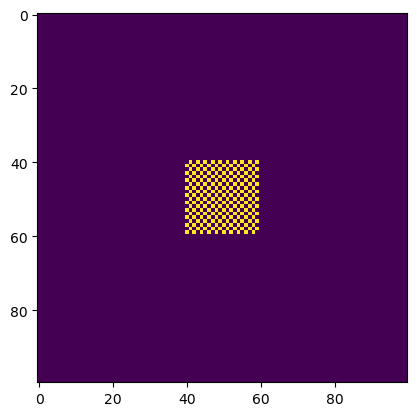

In [19]:
plt.imshow(ds_obs["obstacles"].fillna(0).data[0, ...])


In [20]:
Plat2D.update_jax_interpolant(ds_water)#, ds_seaweed)


In [21]:
times, all_values = hj.solve(solver_settings, Plat2D, grid, times, initial_values, progress_bar=True)


100%|##########| 60.0000/60.0 [00:05<00:00, 11.29sim_s/s]


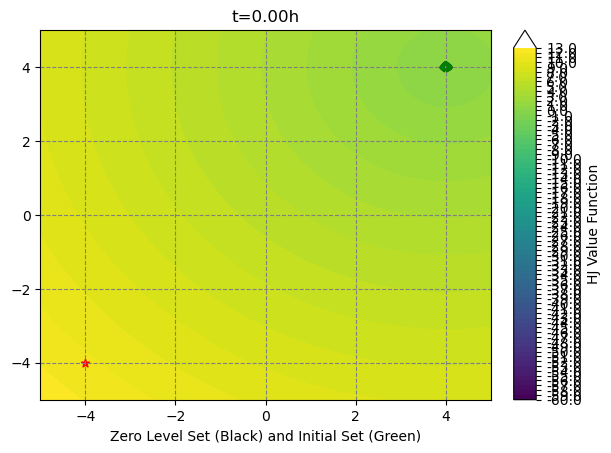

In [22]:
hj.viz.visSet2DAnimation(grid, all_values, times, type='html', x_init=x_init,
        colorbar=True, filename='multireach', interval=120)

In [ ]:
hj.viz.visValFuncTraj(
    ax,
    traj_times=traj_times,
    x_traj=self.planned_trajs[-1]["traj"][:2, :],
    all_times=reach_times,
    all_values=all_values,
    grid=grid,
    flip_times=False,
    ylabel=ylabel,
)